In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import numpy.random as npr
import jax
# np = jax.numpy
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [81]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = lambda X,t: sigma_sq
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.momentum(step_size, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.momentum(step_size, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
        print(dim)
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @staticmethod
    def loss_for_trajectory(Xt, b_f, b_b, dt, theta, forwards = True):
        b_minus  = b_b(theta, Xt)
        b_plus = b_f(theta, Xt)
        
        delta_Xt = Xt[:-1, :]  - Xt[1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[1:,:] - b_minus[:-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum() - 0.5 * time_integral.sum()
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 

    @jit
    def update(self, i, opt_state, batch, forwards=True):
        params = self.get_params(opt_state)
        
        loss = lambda params, batch: self.inner_loss(params, batch, forwards=forwards)
        return self.opt_update(i, grad(loss)(self.theta, batch), opt_state)
        
    def sample_trajectory(self, X, theta, forwards=True):
        
        # backwards discretisation has a sign flip         
        b = self.b_forward if forwards else (lambda X, t, theta: -self.b_backward(X, t, theta))
        
        return self.sde_solver(alfa=b, beta=self.sigma,
                               dt=self.dt, X0=X,
                               N=self.number_time_steps, theta=theta)
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        J = 0
        terminal_index = -1 if forwards else 0
#         X_terminal_empirical = self.X_1 if forwards else self.X_0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        
        for x in batch:
            t, Xt = self.sample_trajectory(x, theta, forwards=forwards)
            
            cross_entropy = log_kde_pdf_per_point(Xt[terminal_index].reshape(-1,1), X_terminal_empirical, H)
            
            J += self.loss_for_trajectory(Xt, self.b_forward, self.b_backward, self.dt, theta, forwards=forwards)
            
            J += cross_entropy
        
        J /= len(batch)
        
        return J
               
    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forwards=True)
        batches_b = self.data_stream(forwards=False)
        
        for i in range(IPFP_iterations):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(num_batches_b):
                    
                    opt_state_b = self.update(
                        next(itercount), opt_state_b, next(batches_b), forwards=False
                    )
                                               
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(num_batches_f):
                    
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), forwards=True
                    )
         

        self.theta_f = get_params(opt_state_f)
        self.theta_b = get_params(opt_state_b)
            
        

In [82]:
X1 = npr.randn(100).reshape(-1,1) - 5
X2 = npr.randn(100).reshape(-1,1) + 5

In [83]:
c = cIPFP(X1, X2,  number_time_steps=100)

1
1


In [79]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)


In [55]:
theta_f[0][1].shape, theta_f[1]

((100,), ())

In [56]:
t, Xt = c.sample_trajectory(X1[0], theta_f)

[-4.2944856]


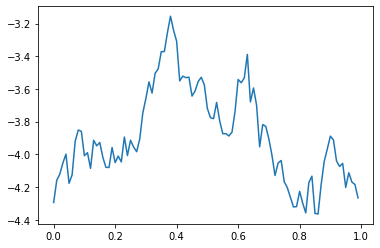

In [57]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [58]:
c.dt

0.01

In [59]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, forwards=True)

In [60]:
loss

DeviceArray(-0.03634034, dtype=float32)

In [61]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [62]:
cross_entropy

DeviceArray([[-144.39993]], dtype=float32)

In [ ]:
c.inner_loss(theta_f, X1)

[-5.44733]
[-5.8358564]
[-4.484774]
[-3.8231993]
[-4.1904416]
[-7.2343597]
[-5.8920317]
[-4.522273]
[-5.727439]
[-3.6175268]
[-6.082919]
[-4.8619103]
[-5.814492]
[-6.094874]
[-4.914796]
[-5.3343964]
[-3.0341783]
[-4.6739974]
[-6.54415]
[-2.8974848]
[-4.3682365]
[-4.3758516]
[-7.1264205]
[-6.3783536]
[-4.97433]
[-4.848971]
[-5.7067876]
[-6.851568]
[-3.4588745]
[-5.9926033]
[-4.940061]
[-5.2245603]
[-5.758835]
[-4.257615]
[-5.736728]
[-3.873409]
[-4.633556]
[-6.586147]
[-5.715542]
[-5.461544]
[-6.353453]
[-5.657418]
[-7.029715]
[-5.5066733]
[-4.184784]
[-4.9390388]
[-4.218155]
[-4.985027]
[-6.1614866]
[-3.9663236]
[-5.62593]
[-5.470446]
[-5.317661]
[-5.2173915]
[-4.16356]
[-4.87592]
[-5.24543]
[-3.7794719]
[-5.879121]
[-6.679446]
[-3.75767]
[-3.7105033]
[-5.3191967]
[-6.050895]
[-6.1982627]
[-4.1979637]
[-4.1584835]
[-5.855035]
[-5.683628]
[-4.7721167]
[-4.3682094]
[-3.9614594]
[-5.0840282]
[-4.789116]
[-3.7127028]
[-5.553354]
[-5.6582074]
[-5.5556726]
[-4.751924]
[-4.954287]
[-3.5886025